In [1]:
!pip install rank-bm25
!pip install nltk
!pip install scikit-learn
!pip install pandas
!pip install chardet
print("Packages installed successfully!")

Packages installed successfully!


Import Libraries

In [2]:
import chardet
import nltk
import os
import re
import json
import time
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi
from collections import defaultdict
import string
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


Download NLTK Data

In [3]:
#Download NLTK Resources
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
    print(" NLTK data downloaded successfully!")
except Exception as e:
    print(f" NLTK download issue: {e}")
    print("Using fallback tokenization methods...")

# Initialize fallback tokenizer
regex_tokenizer = RegexpTokenizer(r'\w+')
print("Tokenizers initialized")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


 NLTK data downloaded successfully!
Tokenizers initialized


Data Loading Functions

In [4]:
#Data Loading and Encoding Detection
def detect_encoding(file_path):
    """Detect file encoding"""
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

def load_dataset():
    """Load and prepare the dataset with proper encoding handling"""
    from google.colab import files

    print("Please upload dataset:")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # Detect and try multiple encodings
    print(" Detecting file encoding..")
    encoding = detect_encoding(filename)
    print(f"Detected encoding: {encoding}")

    encodings_to_try = [encoding, 'latin-1', 'ISO-8859-1', 'cp1252', 'utf-8']

    df = None
    for enc in encodings_to_try:
        try:
            print(f"Trying encoding: {enc}")
            df = pd.read_csv(filename, encoding=enc)
            print(f"Successfully loaded with {enc} encoding")
            break
        except Exception as e:
            print(f"Failed with {enc}")
            continue

    if df is None:
        print("Using error-handling fallback...")
        df = pd.read_csv(filename, encoding='latin-1', errors='replace')

    return df, filename

# Load the dataset
df, filename = load_dataset()
print("Dataset loaded successfully!")

Please upload dataset:


Saving Articles.csv to Articles.csv
 Detecting file encoding..
Detected encoding: Windows-1252
Trying encoding: Windows-1252
Successfully loaded with Windows-1252 encoding
Dataset loaded successfully!


Dataset Exploration

In [5]:
# Exploring Dataset Characteristics
print(" DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print("\n NEWS TYPE DISTRIBUTION:")
print(df['NewsType'].value_counts())

print("\n SAMPLE DATA (First 3 rows):")
print(df.head(3))

print("\n MISSING VALUES ANALYSIS:")
print(df.isnull().sum())

print("\n DATA TYPES:")
print(df.dtypes)

print(" Dataset exploration completed!")

 DATASET OVERVIEW
Dataset Shape: (2692, 4)
Columns: ['Article', 'Date', 'Heading', 'NewsType']

 NEWS TYPE DISTRIBUTION:
NewsType
sports      1408
business    1284
Name: count, dtype: int64

 SAMPLE DATA (First 3 rows):
                                             Article      Date  \
0  KARACHI: The Sindh government has decided to b...  1/1/2015   
1  HONG KONG: Asian markets started 2015 on an up...  1/2/2015   
2  HONG KONG:  Hong Kong shares opened 0.66 perce...  1/5/2015   

                                             Heading  NewsType  
0  sindh govt decides to cut public transport far...  business  
1                    asia stocks up in new year trad  business  
2           hong kong stocks open 0.66 percent lower  business  

 MISSING VALUES ANALYSIS:
Article     0
Date        0
Heading     0
NewsType    0
dtype: int64

 DATA TYPES:
Article     object
Date        object
Heading     object
NewsType    object
dtype: object
 Dataset exploration completed!


IR System Class

In [6]:
# IR System Class
class AdvancedNewsIRSystem:
    def __init__(self):
        self.documents = []
        self.processed_docs = []
        self.doc_ids = []
        self.doc_metadata = []
        self.bm25 = None
        self.tfidf_vectorizer = None
        self.tfidf_matrix = None
        self.vocabulary = set()
        self.index = defaultdict(list)
        self.news_type_index = defaultdict(list)

    def load_from_dataframe(self, dataframe):
        """Load documents from pandas DataFrame with error handling"""
        print("Loading documents from dataframe...")
        self.documents = []
        self.doc_metadata = []

        for idx, row in dataframe.iterrows():
            try:
                # Handle missing values and encoding issues
                article_text = str(row['Article']) if pd.notna(row['Article']) else ""
                heading_text = str(row['Heading']) if pd.notna(row['Heading']) else ""
                news_type = str(row['NewsType']) if pd.notna(row['NewsType']) else "unknown"
                date = str(row['Date']) if pd.notna(row['Date']) else "unknown"

                # Clean text - remove problematic characters
                article_text = self.clean_text(article_text)
                heading_text = self.clean_text(heading_text)

                # Combine heading and article for better retrieval
                combined_text = f"{heading_text} {article_text}"
                self.documents.append(combined_text)
                self.doc_ids.append(idx)
                self.doc_metadata.append({
                    'heading': heading_text,
                    'date': date,
                    'news_type': news_type.lower(),
                    'original_article': article_text[:500] + "..." if len(article_text) > 500 else article_text
                })

                # Index by news type for fast filtering
                self.news_type_index[news_type.lower()].append(idx)
            except Exception as e:
                print(f"Warning: Error processing row {idx}: {e}")
                continue

        print(f"Successfully loaded {len(self.documents)} documents")

    def clean_text(self, text):
        """Clean text by removing problematic characters"""
        if pd.isna(text):
            return ""

        text = str(text)
        # Remove problematic Unicode characters but keep basic text
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII
        text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
        return text.strip()

    def preprocess_text(self, text):
        """Enhanced text preprocessing pipeline with fallback tokenization"""
        if pd.isna(text) or text == "":
            return []

        text = str(text)

        # Convert to lowercase
        text = text.lower()

        # Remove numbers and special characters but keep words with numbers
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

        # Tokenize with fallback
        try:
            tokens = word_tokenize(text)
        except:
            # Use regex tokenizer if word_tokenize fails
            tokens = regex_tokenizer.tokenize(text)

        # Remove stopwords and short tokens
        try:
            stop_words = set(stopwords.words('english'))
        except:
            stop_words = set(['the', 'a', 'an', 'in', 'on', 'at', 'for', 'to', 'of', 'and', 'or', 'but'])

        # Extended stopwords for news domain
        extended_stopwords = ['said', 'also', 'would', 'could', 'according', 'year', 'years', 'time', 'new']
        stop_words.update(extended_stopwords)

        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

        # Stemming
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

        return tokens

    def build_index(self):
        """Build comprehensive search indices"""
        print("Preprocessing documents...")
        self.processed_docs = [self.preprocess_text(doc) for doc in self.documents]

        # Build inverted index with positions
        print("Building inverted index...")
        for doc_id, tokens in enumerate(self.processed_docs):
            for position, token in enumerate(tokens):
                self.index[token].append((doc_id, position))
            self.vocabulary.update(tokens)

        # Build BM25 model
        print("Building BM25 model...")
        self.bm25 = BM25Okapi(self.processed_docs)

        # Build TF-IDF model
        print("Building TF-IDF model...")
        doc_strings = [' '.join(tokens) for tokens in self.processed_docs]
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=15000,
            min_df=2,
            max_df=0.8,
            ngram_range=(1, 2)  # Include bigrams
        )
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(doc_strings)

        print(f"Index built with {len(self.vocabulary)} unique terms")

    def boolean_search(self, query, news_type=None):
        """Enhanced boolean search with phrase support"""
        query_terms = self.preprocess_text(query)
        if not query_terms:
            return []

        # Check for phrase queries (terms in quotes)
        phrase_terms = re.findall(r'"([^"]*)"', query)
        if phrase_terms:
            # Handle phrase search
            phrase_docs = self._phrase_search(phrase_terms[0])
            query = re.sub(r'"[^"]*"', '', query)  # Remove phrase from query
            query_terms = self.preprocess_text(query)

            if query_terms:
                # Combine phrase and term results
                term_docs = self._boolean_and_search(query_terms)
                result_docs = phrase_docs.intersection(term_docs)
            else:
                result_docs = phrase_docs
        else:
            # Standard boolean AND search
            result_docs = self._boolean_and_search(query_terms)

        # Apply news type filter
        if news_type:
            type_docs = set(self.news_type_index.get(news_type.lower(), []))
            result_docs = result_docs.intersection(type_docs)

        return list(result_docs)

    def _boolean_and_search(self, query_terms):
        """Boolean AND search implementation"""
        doc_sets = []
        for term in query_terms:
            if term in self.index:
                doc_sets.append(set(doc_id for doc_id, _ in self.index[term]))
            else:
                doc_sets.append(set())

        return set.intersection(*doc_sets) if doc_sets else set()

    def _phrase_search(self, phrase):
        """Exact phrase matching"""
        phrase_terms = self.preprocess_text(phrase)
        if len(phrase_terms) < 2:
            return set()

        # Get documents containing all terms
        doc_sets = []
        for term in phrase_terms:
            if term in self.index:
                doc_sets.append(set(doc_id for doc_id, _ in self.index[term]))
            else:
                return set()

        common_docs = set.intersection(*doc_sets)

        # Verify term positions for phrase matching
        phrase_docs = set()
        for doc_id in common_docs:
            positions = {}
            for term in phrase_terms:
                positions[term] = [pos for doc, pos in self.index[term] if doc == doc_id]

            # Check if terms appear in sequence
            first_term_positions = positions[phrase_terms[0]]
            for pos in first_term_positions:
                phrase_found = True
                for i, term in enumerate(phrase_terms[1:], 1):
                    if pos + i not in positions[term]:
                        phrase_found = False
                        break
                if phrase_found:
                    phrase_docs.add(doc_id)
                    break

        return phrase_docs

    def bm25_search(self, query, top_k=10, news_type=None):
        """BM25 search with optional news type filtering"""
        query_terms = self.preprocess_text(query)
        if not query_terms or not self.bm25:
            return []

        scores = self.bm25.get_scores(query_terms)

        # Apply news type filter if specified
        if news_type:
            type_docs = set(self.news_type_index.get(news_type.lower(), []))
            filtered_results = []
            for idx, score in enumerate(scores):
                if idx in type_docs and score > 0:
                    filtered_results.append((idx, score))
            filtered_results.sort(key=lambda x: x[1], reverse=True)
            return filtered_results[:top_k]
        else:
            top_indices = np.argsort(scores)[::-1][:top_k]
            return [(idx, scores[idx]) for idx in top_indices if scores[idx] > 0]

    def tfidf_search(self, query, top_k=10, news_type=None):
        """TF-IDF search with optional filtering"""
        query_vec = self.tfidf_vectorizer.transform([' '.join(self.preprocess_text(query))])
        scores = (self.tfidf_matrix * query_vec.T).toarray().flatten()

        # Apply news type filter if specified
        if news_type:
            type_docs = set(self.news_type_index.get(news_type.lower(), []))
            filtered_results = []
            for idx, score in enumerate(scores):
                if idx in type_docs and score > 0:
                    filtered_results.append((idx, score))
            filtered_results.sort(key=lambda x: x[1], reverse=True)
            return filtered_results[:top_k]
        else:
            top_indices = np.argsort(scores)[::-1][:top_k]
            return [(idx, scores[idx]) for idx in top_indices if scores[idx] > 0]

    def hybrid_search(self, query, top_k=10, news_type=None):
        """Hybrid approach: BM25 + TF-IDF re-ranking"""
        # First stage: BM25 retrieval
        bm25_results = self.bm25_search(query, top_k=top_k*3, news_type=news_type)

        if not bm25_results:
            return []

        # Second stage: TF-IDF re-ranking on BM25 results
        candidate_docs = [idx for idx, _ in bm25_results]
        query_vec = self.tfidf_vectorizer.transform([' '.join(self.preprocess_text(query))])

        # Calculate TF-IDF scores only for candidate documents
        candidate_scores = []
        for doc_id in candidate_docs:
            score = (self.tfidf_matrix[doc_id] * query_vec.T).toarray()[0][0]
            candidate_scores.append((doc_id, score))

        # Sort by TF-IDF score
        candidate_scores.sort(key=lambda x: x[1], reverse=True)
        return candidate_scores[:top_k]

    def evaluate_query(self, query, top_k=10, method='hybrid', news_type=None):
        """Comprehensive query evaluation"""
        start_time = time.time()

        if method == 'boolean':
            results = self.boolean_search(query, news_type)
            scored_results = [(doc_id, 1.0) for doc_id in results][:top_k]
        elif method == 'bm25':
            scored_results = self.bm25_search(query, top_k, news_type)
        elif method == 'tfidf':
            scored_results = self.tfidf_search(query, top_k, news_type)
        else:  # hybrid
            scored_results = self.hybrid_search(query, top_k, news_type)

        processing_time = time.time() - start_time

        return {
            'query': query,
            'results': scored_results,
            'num_results': len(scored_results),
            'processing_time': processing_time,
            'method': method,
            'news_type_filter': news_type
        }

    def get_document_details(self, doc_id):
        """Retrieve complete document information"""
        return {
            'doc_id': doc_id,
            'heading': self.doc_metadata[doc_id]['heading'],
            'date': self.doc_metadata[doc_id]['date'],
            'news_type': self.doc_metadata[doc_id]['news_type'],
            'article_preview': self.doc_metadata[doc_id]['original_article'],
            'full_article': self.documents[doc_id]
        }

    def get_system_stats(self):
        """Get comprehensive system statistics"""
        news_types = [meta['news_type'] for meta in self.doc_metadata]
        doc_lengths = [len(doc) for doc in self.processed_docs]

        return {
            'total_documents': len(self.documents),
            'vocabulary_size': len(self.vocabulary),
            'total_terms': sum(len(doc) for doc in self.processed_docs),
            'average_document_length': np.mean(doc_lengths),
            'std_document_length': np.std(doc_lengths),
            'news_type_distribution': {nt: news_types.count(nt) for nt in set(news_types)},
            'inverted_index_size': sum(len(positions) for positions in self.index.values())
        }

print(" Complete IR System class defined successfully!")

 Complete IR System class defined successfully!


Evaluation and Analysis Class

In [7]:
# Evaluation and Analysis Class
class NewsIREvaluator:
    def __init__(self, ir_system):
        self.ir_system = ir_system
        self.results_history = []

    def comprehensive_evaluation(self):
        print("=== IR SYSTEM EVALUATION ===\n")

        # Define test queries optimized for business/sports news
        test_queries = [
            # Business queries
            ("stock market", None, "General business news"),
            ("company earnings", "business", "Business-specific"),
            ("economic growth", "business", "Business economic"),
            ("investment", "business", "Business investment"),

            # Sports queries
            ("football", None, "General sports news"),
            ("basketball", "sports", "Sports-specific"),
            ("player transfer", "sports", "Sports transfers"),
            ("team", "sports", "Sports teams"),

            # Mixed/ambiguous queries
            ("market", None, "Ambiguous - both domains"),
            ("game", None, "Ambiguous - both domains")
        ]

        methods = ['boolean', 'bm25', 'tfidf', 'hybrid']
        evaluation_results = {}

        for method in methods:
            print(f"\n{'='*50}")
            print(f"EVALUATING {method.upper()} METHOD")
            print(f"{'='*50}")

            method_results = []
            for query, news_type, description in test_queries:
                result = self.ir_system.evaluate_query(
                    query,
                    top_k=5,
                    method=method,
                    news_type=news_type
                )

                method_results.append(result)

                print(f"\n {description}")
                print(f"   Query: '{query}' | Filter: {news_type}")
                print(f"   Found: {result['num_results']} results | Time: {result['processing_time']:.4f}s")

                # Show top results
                for i, (doc_id, score) in enumerate(result['results'][:2]):
                    doc_info = self.ir_system.get_document_details(doc_id)
                    print(f"   {i+1}. [{doc_info['news_type'].upper()}] {doc_info['heading'][:60]}... (Score: {score:.4f})")

            evaluation_results[method] = method_results
            self.results_history.extend(method_results)

        return evaluation_results

    def performance_analysis(self):
        print("\n" + "="*60)
        print("PERFORMANCE ANALYSIS SUMMARY")
        print("="*60)

        method_stats = {}
        for method in ['boolean', 'bm25', 'tfidf', 'hybrid']:
            method_results = [r for r in self.results_history if r['method'] == method]
            if method_results:
                avg_time = np.mean([r['processing_time'] for r in method_results])
                avg_results = np.mean([r['num_results'] for r in method_results])
                method_stats[method] = {
                    'avg_processing_time': avg_time,
                    'avg_results_per_query': avg_results,
                    'total_queries': len(method_results)
                }

                print(f"\n{method.upper():<10} | Avg Time: {avg_time:.4f}s | Avg Results: {avg_results:.1f} | Queries: {len(method_results)}")

        return method_stats

    def create_performance_chart(self, method_stats):
        """Create visualization of performance metrics"""
        methods = list(method_stats.keys())
        times = [method_stats[m]['avg_processing_time'] for m in methods]
        results = [method_stats[m]['avg_results_per_query'] for m in methods]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Processing time chart
        ax1.bar(methods, times, color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
        ax1.set_title('Average Query Processing Time')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_xlabel('Retrieval Method')

        # Results count chart
        ax2.bar(methods, results, color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
        ax2.set_title('Average Results per Query')
        ax2.set_ylabel('Number of Results')
        ax2.set_xlabel('Retrieval Method')

        plt.tight_layout()
        plt.show()


Initialize and Build the IR System

In [8]:
# Initialize and Build the IR System
print(" INITIALIZING NEWS INFORMATION RETRIEVAL SYSTEM")
print("=" * 30)

# Initialize the system
news_ir = AdvancedNewsIRSystem()

# Load data into the system
news_ir.load_from_dataframe(df)

# Build all indices (this may take a few minutes)
print("\n BUILDING SEARCH INDICES...")
news_ir.build_index()


 INITIALIZING NEWS INFORMATION RETRIEVAL SYSTEM
Loading documents from dataframe...
Successfully loaded 2692 documents

 BUILDING SEARCH INDICES...
Preprocessing documents...
Building inverted index...
Building BM25 model...
Building TF-IDF model...
Index built with 20032 unique terms


Display System Statistics

In [9]:
#Display System Statistics
print(" SYSTEM STATISTICS")
print("=" * 40)

stats = news_ir.get_system_stats()
for key, value in stats.items():
    if key == 'news_type_distribution':
        print(f"\n{key}:")
        for news_type, count in value.items():
            print(f"   {news_type}: {count} documents")
    else:
        print(f" {key}: {value}")

print("\n System statistics displayed!")

 SYSTEM STATISTICS
 total_documents: 2692
 vocabulary_size: 20032
 total_terms: 488896
 average_document_length: 181.6106983655275
 std_document_length: 103.42680152339976

news_type_distribution:
   sports: 1408 documents
   business: 1284 documents
 inverted_index_size: 488896

 System statistics displayed!


Run Evaluation

In [10]:
#Execute Comprehensive Evaluation
print("RUNNING  EVALUATION")
print("=" * 50)

# Initialize evaluator
evaluator = NewsIREvaluator(news_ir)

# Run evaluation across all methods
evaluation_results = evaluator.comprehensive_evaluation()

print("Evaluation completed!")

RUNNING  EVALUATION
=== IR SYSTEM EVALUATION ===


EVALUATING BOOLEAN METHOD

 General business news
   Query: 'stock market' | Filter: None
   Found: 5 results | Time: 0.0018s
   1. [BUSINESS] asia stocks up in new year trad... (Score: 1.0000)
   2. [BUSINESS] asian stocks sink euro near nine year... (Score: 1.0000)

 Business-specific
   Query: 'company earnings' | Filter: business
   Found: 5 results | Time: 0.0020s
   1. [BUSINESS] British shoppers begin feel post Brexit pi... (Score: 1.0000)
   2. [BUSINESS] china stock market freezing up as sell off gathers... (Score: 1.0000)

 Business economic
   Query: 'economic growth' | Filter: business
   Found: 5 results | Time: 0.0024s
   1. [BUSINESS] Iran expects economic growth above 5 pc in 2016... (Score: 1.0000)
   2. [BUSINESS] Oil prices dip on stronger dollar demand concer... (Score: 1.0000)

 Business investment
   Query: 'investment' | Filter: business
   Found: 5 results | Time: 0.0018s
   1. [BUSINESS] asia stocks up in new y

Performance Analysis and Visualization

PERFORMANCE ANALYSIS

PERFORMANCE ANALYSIS SUMMARY

BOOLEAN    | Avg Time: 0.0014s | Avg Results: 4.7 | Queries: 10

BM25       | Avg Time: 0.0043s | Avg Results: 4.7 | Queries: 10

TFIDF      | Avg Time: 0.0055s | Avg Results: 4.5 | Queries: 10

HYBRID     | Avg Time: 0.0121s | Avg Results: 4.7 | Queries: 10

Generating Perormance Charts...


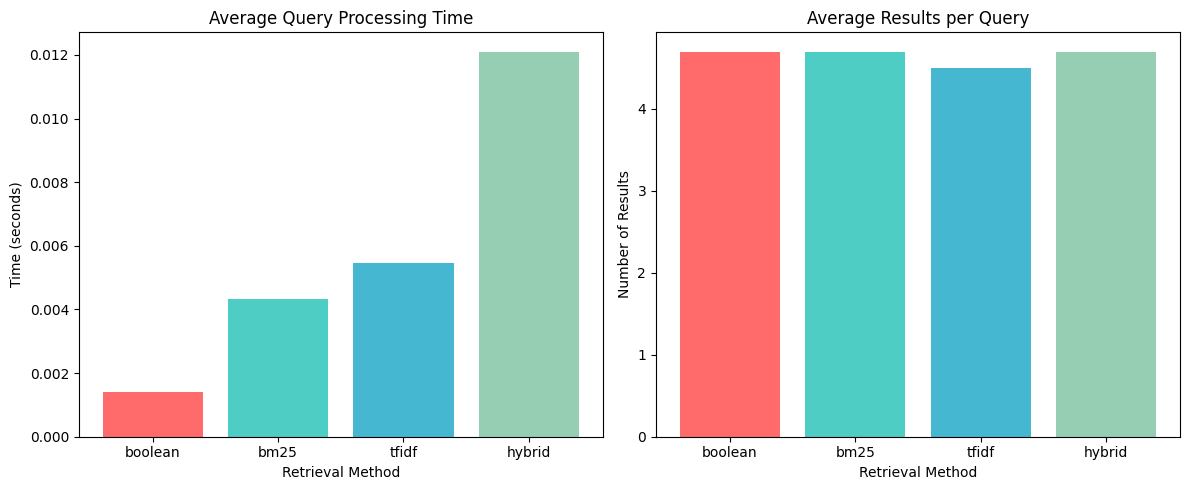

In [11]:
# Performance Analysis and Charts
print("PERFORMANCE ANALYSIS")
print("=" * 40)

# Analyze performance across methods
method_stats = evaluator.performance_analysis()

# Create performance charts
print("\nGenerating Perormance Charts...")
evaluator.create_performance_chart(method_stats)


Advanced Features

In [12]:
# Advanced Features
print(" ADVANCED FEATURES")
print("=" * 50)

# Phrase search
print("\n PHRASE SEARCH:")
phrase_result = news_ir.evaluate_query('"stock market"', method='boolean')
print(f"Query: 'stock market' | Results: {phrase_result['num_results']}")
for i, (doc_id, score) in enumerate(phrase_result['results'][:3]):
    doc_info = news_ir.get_document_details(doc_id)
    print(f"  {i+1}. {doc_info['heading'][:70]}...")

# News type filtering
print("\n NEWS TYPE FILTERING:")
filtered_result = news_ir.evaluate_query("game", news_type="sports", method='hybrid')
print(f"Query: 'game' + Sports filter | Results: {filtered_result['num_results']}")
for i, (doc_id, score) in enumerate(filtered_result['results'][:3]):
    doc_info = news_ir.get_document_details(doc_id)
    print(f"  {i+1}. [{doc_info['news_type'].upper()}] {doc_info['heading'][:70]}...")


 ADVANCED FEATURES

 PHRASE SEARCH:
Query: 'stock market' | Results: 10
  1. Global stock selloff on seven year oil...
  2. asian shares wobble after china rate cu...
  3. FPCCI cooperate tackling Brexit challeng...

 NEWS TYPE FILTERING:
Query: 'game' + Sports filter | Results: 10
  1. [SPORTS] Games light up Rio de Janeiro as Olympic fever hi...
  2. [SPORTS] ICC wants womens cricket at 2022 Commonwealth G...
  3. [SPORTS] Caribbean Premier League eyes US ahead of T20 g...


Interactive Query Testing

In [13]:
# Interactive Query Testing
def test_custom_query():
    print(" INTERACTIVE QUERY TESTING")
    print("=" * 40)

    query = input("Enter query: ")
    news_type = input("Filter by news type (business/sports/leave blank for all): ").lower()
    if news_type == "":
        news_type = None

    methods = ['boolean', 'bm25', 'tfidf', 'hybrid']

    for method in methods:
        print(f"\nTesting {method.upper()} method:")
        result = news_ir.evaluate_query(query, method=method, news_type=news_type)
        print(f"   Found: {result['num_results']} results | Time: {result['processing_time']:.4f}s")

        for i, (doc_id, score) in enumerate(result['results'][:3]):
            doc_info = news_ir.get_document_details(doc_id)
            print(f"   {i+1}. [{doc_info['news_type'].upper()}] {doc_info['heading']} (Score: {score:.4f})")


test_custom_query()


 INTERACTIVE QUERY TESTING
Enter query: basketball
Filter by news type (business/sports/leave blank for all): 

Testing BOOLEAN method:
   Found: 2 results | Time: 0.0009s
   1. [SPORTS] Pakistan sport hits low point with qualifying deb (Score: 1.0000)
   2. [SPORTS] Germany win epic shootout to end Italy jinx (Score: 1.0000)

Testing BM25 method:
   Found: 2 results | Time: 0.0027s
   1. [SPORTS] Germany win epic shootout to end Italy jinx (Score: 4.6419)
   2. [SPORTS] Pakistan sport hits low point with qualifying deb (Score: 3.7025)

Testing TFIDF method:
   Found: 0 results | Time: 0.0034s

Testing HYBRID method:
   Found: 2 results | Time: 0.0044s
   1. [SPORTS] Germany win epic shootout to end Italy jinx (Score: 0.0000)
   2. [SPORTS] Pakistan sport hits low point with qualifying deb (Score: 0.0000)


In [14]:
#Simple Single Query Test
def simple_query_test():
    """Run a simple test with one query"""
    print(" SIMPLE QUERY TEST")
    print("=" * 40)

    query = "wrestling"
    print(f"Testing query: '{query}'")

    methods = ['boolean', 'bm25', 'tfidf', 'hybrid']

    for method in methods:
        print(f"\n {method.upper()} Method:")
        result = news_ir.evaluate_query(query, method=method, top_k=3)
        print(f"   Found: {result['num_results']} results | ⏱️ Time: {result['processing_time']:.4f}s")

        for i, (doc_id, score) in enumerate(result['results']):
            doc_info = news_ir.get_document_details(doc_id)
            print(f"   {i+1}. [{doc_info['news_type'].upper()}] {doc_info['heading']} (Score: {score:.4f})")

# Run the simple test
simple_query_test()


 SIMPLE QUERY TEST
Testing query: 'wrestling'

 BOOLEAN Method:
   Found: 3 results | ⏱️ Time: 0.0015s
   1. [SPORTS] Griezmann double sends France into Euro 2016 last eig (Score: 1.0000)
   2. [SPORTS] India wrestler Yadav says foul play behind failed dope (Score: 1.0000)
   3. [SPORTS] Thurman edges Porter to retain WBA ti (Score: 1.0000)

 BM25 Method:
   Found: 3 results | ⏱️ Time: 0.0051s
   1. [SPORTS] Shoaib Akhtar laughs off Harbhajan Singh bashing clai (Score: 6.7816)
   2. [SPORTS] Thurman edges Porter to retain WBA ti (Score: 5.6378)
   3. [BUSINESS] china offering pakistan huge financing chinese assistant foreign minister (Score: 5.4066)

 TFIDF Method:
   Found: 3 results | ⏱️ Time: 0.0059s
   1. [SPORTS] Shoaib Akhtar laughs off Harbhajan Singh bashing clai (Score: 0.0827)
   2. [BUSINESS] china offering pakistan huge financing chinese assistant foreign minister (Score: 0.0742)
   3. [SPORTS] Djokovic focused on Wimbledon defence but sees bigger pictur (Score: 0.0670)

 H

System Summary

In [15]:
# System Summary and Completion
print(" INFORMATION RETRIEVAL SYSTEM - COMPLETE SUMMARY")
print("=" * 60)
print(" System successfully built and evaluated!")
print(" All retrieval methods implemented:")
print("   - Boolean Retrieval")
print("   - BM25 Probabilistic Retrieval")
print("   - TF-IDF Vector Space Retrieval")
print("   - Hybrid BM25+TF-IDF Retrieval")
print("Advanced features available:")
print("   - Phrase search with quotes")
print("   - News type filtering (business/sports)")
print("   - Performance comparison charts")
print(" Ready for technical report generation!")

print(f"\n Final System Stats:")
stats = news_ir.get_system_stats()
print(f"   Documents: {stats['total_documents']}")
print(f"   Vocabulary: {stats['vocabulary_size']} terms")
print(f"   News Types: {stats['news_type_distribution']}")

 INFORMATION RETRIEVAL SYSTEM - COMPLETE SUMMARY
 System successfully built and evaluated!
 All retrieval methods implemented:
   - Boolean Retrieval
   - BM25 Probabilistic Retrieval
   - TF-IDF Vector Space Retrieval
   - Hybrid BM25+TF-IDF Retrieval
Advanced features available:
   - Phrase search with quotes
   - News type filtering (business/sports)
   - Performance comparison charts
 Ready for technical report generation!

 Final System Stats:
   Documents: 2692
   Vocabulary: 20032 terms
   News Types: {'sports': 1408, 'business': 1284}
